In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # Suppress the warning


pd.reset_option('display.max_rows')

df = pd.read_csv('sample_data/BNCF_TankVRU_2023-Nov-29_09-50-38.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df_inst = df[(df['Description'] == 'Oil Flow Rate') & (df['PointIdLong'] == 'BRIGGSNORTH_HT_OM_RTOILXIN')]
df_daily = df[(df['Description'] == 'Oil Daily Volume') & (df['PointIdLong'] == 'BRIGGSNORTH_HT_OM_QTOILD')]

In [2]:
df_daily['Reset'] = df_daily['Value'].diff() < -1
df_daily['Day_Group'] = df_daily['Reset'].cumsum()
df_daily['Step_Value'] = df_daily.groupby('Day_Group')['Value'].transform('max')
df_daily = df_daily.drop(columns=['Reset', 'Day_Group'])

df_daily.head()

,PointIdLong,Description,Timestamp,Value,Step_Value
220378,BRIGGSNORTH_HT_OM_QTOILD,Oil Daily Volume,2023-07-01 08:59:05,372.4995,544.3162
220379,BRIGGSNORTH_HT_OM_QTOILD,Oil Daily Volume,2023-07-01 09:00:03,372.7309,544.3162
220380,BRIGGSNORTH_HT_OM_QTOILD,Oil Daily Volume,2023-07-01 09:01:03,372.9680,544.3162
220381,BRIGGSNORTH_HT_OM_QTOILD,Oil Daily Volume,2023-07-01 09:02:05,373.1640,544.3162
220382,BRIGGSNORTH_HT_OM_QTOILD,Oil Daily Volume,2023-07-01 09:03:03,373.3705,544.3162


In [3]:
# Ensure timestamps are in datetime format
df_inst['Timestamp'] = pd.to_datetime(df_inst['Timestamp'])
df_daily['Timestamp'] = pd.to_datetime(df_daily['Timestamp'])

# Step 1: Adjust `df_daily` to force resets at 16:28:00
df_daily['Forced_Timestamp'] = df_daily['Timestamp'].dt.floor('D') + pd.Timedelta(hours=16, minutes=28)

# Step 2: Handle the first day explicitly
first_day = df_daily.iloc[0]['Forced_Timestamp'] - pd.Timedelta(days=1)
df_daily.loc[-1] = {'Forced_Timestamp': first_day, 'Step_Value': df_daily.iloc[0]['Step_Value']}
df_daily.sort_values('Forced_Timestamp', inplace=True)

# Step 3: Create a mapping range in `df_daily`
df_daily['Next_Forced_Timestamp'] = df_daily['Forced_Timestamp'].shift(-1, fill_value=pd.Timestamp.max)

# Step 4: Merge `df_inst` with the daily step values from `df_daily`
df_new = pd.merge_asof(
    df_inst.sort_values('Timestamp'),
    df_daily[['Forced_Timestamp', 'Step_Value']].rename(columns={'Forced_Timestamp': 'Start_Timestamp'}),
    left_on='Timestamp',
    right_on='Start_Timestamp',
    direction='backward'
)

# Drop unnecessary columns
df_new.drop(columns=['Start_Timestamp'], inplace=True)


C:\Users\EricKim\AppData\Local\Temp\ipykernel_17820\3360099223.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_daily.loc[-1] = {'Forced_Timestamp': first_day, 'Step_Value': df_daily.iloc[0]['Step_Value']}


In [4]:
pd.set_option('display.max_rows', None)

df_new['Step_Value'][:10000]

# Reset to default
pd.reset_option('display.max_rows')

df_new

,PointIdLong,Description,Timestamp,Value,Step_Value
0,BRIGGSNORTH_HT_OM_RTOILXIN,Oil Flow Rate,2023-07-01 08:59:05,0.0000,544.3162
1,BRIGGSNORTH_HT_OM_RTOILXIN,Oil Flow Rate,2023-07-01 09:01:03,311.1740,544.3162
2,BRIGGSNORTH_HT_OM_RTOILXIN,Oil Flow Rate,2023-07-01 09:02:05,0.0000,544.3162
3,BRIGGSNORTH_HT_OM_RTOILXIN,Oil Flow Rate,2023-07-01 09:03:03,1942.4800,544.3162
4,BRIGGSNORTH_HT_OM_RTOILXIN,Oil Flow Rate,2023-07-01 09:04:04,0.0000,544.3162
...,...,...,...,...,...
86369,BRIGGSNORTH_HT_OM_RTOILXIN,Oil Flow Rate,2023-09-30 08:50:06,189.9645,2180.8130
86370,BRIGGSNORTH_HT_OM_RTOILXIN,Oil Flow Rate,2023-09-30 08:50:12,10629.3800,2180.8130
86371,BRIGGSNORTH_HT_OM_RTOILXIN,Oil Flow Rate,2023-09-30 08:51:03,0.0000,2180.8130
86372,BRIGGSNORTH_HT_OM_RTOILXIN,Oil Flow Rate,2023-09-30 08:57:03,10258.0800,2180.8130


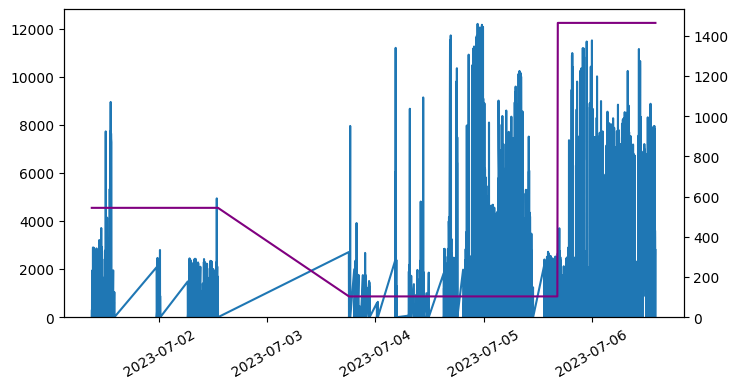

In [5]:
s = 0
n = 3000

fig, ax = plt.subplots(figsize=(8, 4))

ax2 = ax.twinx()

ax.plot(df_new.iloc[s:s+n, :]['Timestamp'], df_new.iloc[s:s+n, :]['Value'])
ax2.plot(df_new.iloc[s:s+n, :]['Timestamp'], df_new.iloc[s:s+n, :]['Step_Value'], color='purple')

ax.set_ylim(0, None)
ax2.set_ylim(0, None)

ax.tick_params(axis='x', labelrotation=30)

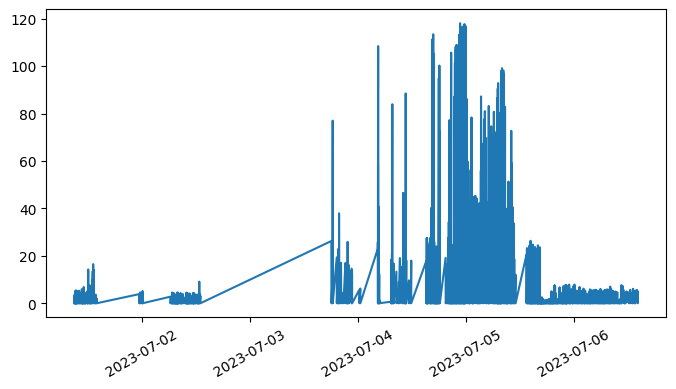

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(df_new.iloc[s:s+n, :]['Timestamp'], df_new.iloc[s:s+n, :]['Value'] / df_new.iloc[s:s+n, :]['Step_Value'])

ax.tick_params(axis='x', labelrotation=30)

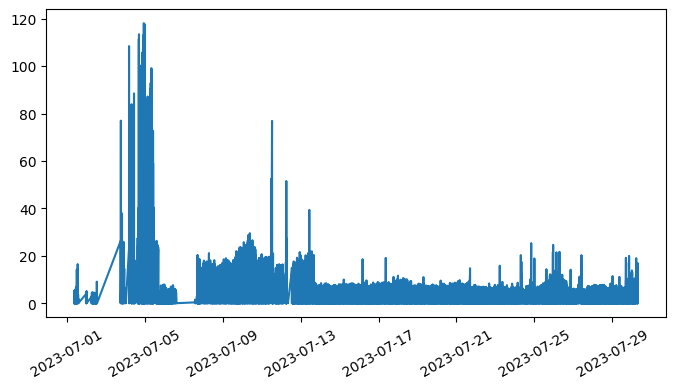

In [7]:

n = 20000

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(df_new.iloc[:n, :]['Timestamp'], df_new.iloc[:n, :]['Value'] / df_new.iloc[:n, :]['Step_Value'])

ax.tick_params(axis='x', labelrotation=30)

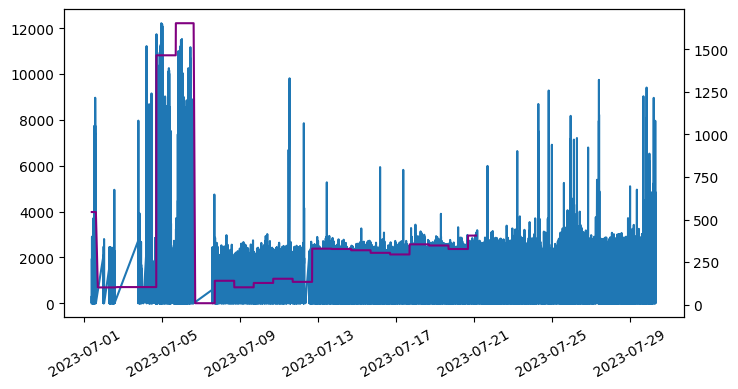

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # Suppress the warning

# Reset to default
pd.reset_option('display.max_rows')

df = pd.read_csv('sample_data/BNCF_TankVRU_2023-Nov-29_09-50-38.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df_inst = df[(df['Description'] == 'Oil Flow Rate') & (df['PointIdLong'] == 'BRIGGSNORTH_HT_OM_RTOILXIN')]
df_daily = df[(df['Description'] == 'Oil Daily Volume') & (df['PointIdLong'] == 'BRIGGSNORTH_HT_OM_QTOILD')]

df_daily['Reset'] = df_daily['Value'].diff() < -1
df_daily['Day_Group'] = df_daily['Reset'].cumsum()
df_daily['Step_Value'] = df_daily.groupby('Day_Group')['Value'].transform('max')
df_daily = df_daily.drop(columns=['Reset', 'Day_Group'])

df_daily.head()


n = 20000

fig, ax = plt.subplots(figsize=(8, 4))

ax2 = ax.twinx()

ax.plot(df_inst.iloc[:n, :]['Timestamp'], df_inst.iloc[:n, :]['Value'])
ax2.plot(df_daily.iloc[:n, :]['Timestamp'], df_daily.iloc[:n, :]['Step_Value'], color='purple')

ax.tick_params(axis='x', labelrotation=30)

In [9]:
df_daily['Step_Value']

220378     544.3162
220379     544.3162
220380     544.3162
220381     544.3162
220382     544.3162
            ...    
340114    1619.0900
340115    1619.0900
340116    1619.0900
340117    1619.0900
340118    1619.0900
Name: Step_Value, Length: 119741, dtype: float64

In [10]:
df_inst['Value'] / df_daily['Step_Value']

134004   NaN
134005   NaN
134006   NaN
134007   NaN
134008   NaN
          ..
340114   NaN
340115   NaN
340116   NaN
340117   NaN
340118   NaN
Length: 206115, dtype: float64

In [11]:
df_inst['Value']

134004        0.0000
134005      311.1740
134006        0.0000
134007     1942.4800
134008        0.0000
             ...    
220373      189.9645
220374    10629.3800
220375        0.0000
220376    10258.0800
220377        0.0000
Name: Value, Length: 86374, dtype: float64

In [12]:
df_daily['Step_Value']

220378     544.3162
220379     544.3162
220380     544.3162
220381     544.3162
220382     544.3162
            ...    
340114    1619.0900
340115    1619.0900
340116    1619.0900
340117    1619.0900
340118    1619.0900
Name: Step_Value, Length: 119741, dtype: float64

In [13]:
import pandas as pd

# Ensure timestamps are in datetime format
df_inst['Timestamp'] = pd.to_datetime(df_inst['Timestamp'])
df_daily['Timestamp'] = pd.to_datetime(df_daily['Timestamp'])

# Create a new column in `df_daily` for day extraction
df_daily['Date'] = df_daily['Timestamp'].dt.date
df_inst['Date'] = df_inst['Timestamp'].dt.date

# Count the number of rows in `df_inst` for each day
inst_counts = df_inst.groupby('Date').size().reset_index(name='Inst_Count')

# Count the number of rows in `df_daily` for each day
daily_counts = df_daily.groupby('Date').size().reset_index(name='Daily_Count')

# Merge the two counts
comparison = pd.merge(inst_counts, daily_counts, on='Date', how='outer').fillna(0)

# Calculate the ratio
comparison['Ratio'] = comparison['Inst_Count'] / comparison['Daily_Count']


In [14]:
comparison

,Date,Inst_Count,Daily_Count,Ratio
0,2023-07-01,227,315,0.720635
1,2023-07-02,271,415,0.653012
2,2023-07-03,61,121,0.504132
3,2023-07-04,389,613,0.634584
4,2023-07-05,1225,1289,0.950349
...,...,...,...,...
87,2023-09-26,974,1462,0.666211
88,2023-09-27,1201,1538,0.780884
89,2023-09-28,1162,1515,0.766997
90,2023-09-29,1045,1480,0.706081


# Cumulative Divide

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
pd.options.mode.chained_assignment = None  # Suppress the warning


pd.reset_option('display.max_rows')

df = pd.read_csv('sample_data/BNCF_TankVRU_2023-Nov-29_09-50-38.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df_daily = df[(df['Description'] == 'Oil Daily Volume') & (df['PointIdLong'] == 'BRIGGSNORTH_HT_OM_QTOILD')]
df_press = df[(df['Description'] == 'HT Press') & (df['PointIdLong'] == 'BRIGGSNORTH_HT_GM_PRHTXIN')]

In [62]:
df_daily.head()

,PointIdLong,Description,Timestamp,Value
220378,BRIGGSNORTH_HT_OM_QTOILD,Oil Daily Volume,2023-07-01 08:59:05,372.4995
220379,BRIGGSNORTH_HT_OM_QTOILD,Oil Daily Volume,2023-07-01 09:00:03,372.7309
220380,BRIGGSNORTH_HT_OM_QTOILD,Oil Daily Volume,2023-07-01 09:01:03,372.9680
220381,BRIGGSNORTH_HT_OM_QTOILD,Oil Daily Volume,2023-07-01 09:02:05,373.1640
220382,BRIGGSNORTH_HT_OM_QTOILD,Oil Daily Volume,2023-07-01 09:03:03,373.3705


In [66]:
df_press.head()

,PointIdLong,Description,Timestamp,Value
0,BRIGGSNORTH_HT_GM_PRHTXIN,HT Press,2023-07-01 08:34:37,47.41875
1,BRIGGSNORTH_HT_GM_PRHTXIN,HT Press,2023-07-01 09:21:28,48.32813
2,BRIGGSNORTH_HT_GM_PRHTXIN,HT Press,2023-07-01 09:21:38,48.45000
3,BRIGGSNORTH_HT_GM_PRHTXIN,HT Press,2023-07-01 09:25:08,47.45625
4,BRIGGSNORTH_HT_GM_PRHTXIN,HT Press,2023-07-01 09:25:18,47.40938


In [63]:
df_daily['Reset'] = df_daily['Value'].diff() < -1
df_daily['Day_Group'] = df_daily['Reset'].cumsum()
df_daily['Step_Value'] = df_daily.groupby('Day_Group')['Value'].transform('max')
df_daily = df_daily.drop(columns=['Reset', 'Day_Group'])

df_daily['Value_Diff'] = df_daily['Value'].diff()  # Difference in values
df_daily['Time_Diff'] = df_daily['Timestamp'].diff().dt.total_seconds()  # Time difference in seconds
df_daily['Inst_Flow_Rate'] = (df_daily['Value_Diff'] / df_daily['Time_Diff']) * 86400  # Scale to seconds in a day
df_daily = df_daily.iloc[1:, :]
df_daily['Inst / Cum Ratio'] = df_daily['Inst_Flow_Rate'] / df_daily['Step_Value']

In [64]:
pd.set_option('display.min_rows', 10)
df_daily

,PointIdLong,Description,Timestamp,Value,Step_Value,Value_Diff,Time_Diff,Inst_Flow_Rate,Inst / Cum Ratio
220379,BRIGGSNORTH_HT_OM_QTOILD,Oil Daily Volume,2023-07-01 09:00:03,372.7309,544.3162,0.2314,58.0,344.706207,0.633283
220380,BRIGGSNORTH_HT_OM_QTOILD,Oil Daily Volume,2023-07-01 09:01:03,372.9680,544.3162,0.2371,60.0,341.424000,0.627253
220381,BRIGGSNORTH_HT_OM_QTOILD,Oil Daily Volume,2023-07-01 09:02:05,373.1640,544.3162,0.1960,62.0,273.135484,0.501796
220382,BRIGGSNORTH_HT_OM_QTOILD,Oil Daily Volume,2023-07-01 09:03:03,373.3705,544.3162,0.2065,58.0,307.613793,0.565138
220383,BRIGGSNORTH_HT_OM_QTOILD,Oil Daily Volume,2023-07-01 09:04:04,373.4678,544.3162,0.0973,61.0,137.815082,0.253189
...,...,...,...,...,...,...,...,...,...
340114,BRIGGSNORTH_HT_OM_QTOILD,Oil Daily Volume,2023-09-30 08:55:03,1615.3930,1619.0900,1.1540,96.0,1038.600000,0.641471
340115,BRIGGSNORTH_HT_OM_QTOILD,Oil Daily Volume,2023-09-30 08:56:03,1616.6140,1619.0900,1.2210,60.0,1758.240000,1.085943
340116,BRIGGSNORTH_HT_OM_QTOILD,Oil Daily Volume,2023-09-30 08:57:03,1617.4070,1619.0900,0.7930,60.0,1141.920000,0.705285
340117,BRIGGSNORTH_HT_OM_QTOILD,Oil Daily Volume,2023-09-30 08:58:05,1617.6520,1619.0900,0.2450,62.0,341.419355,0.210871


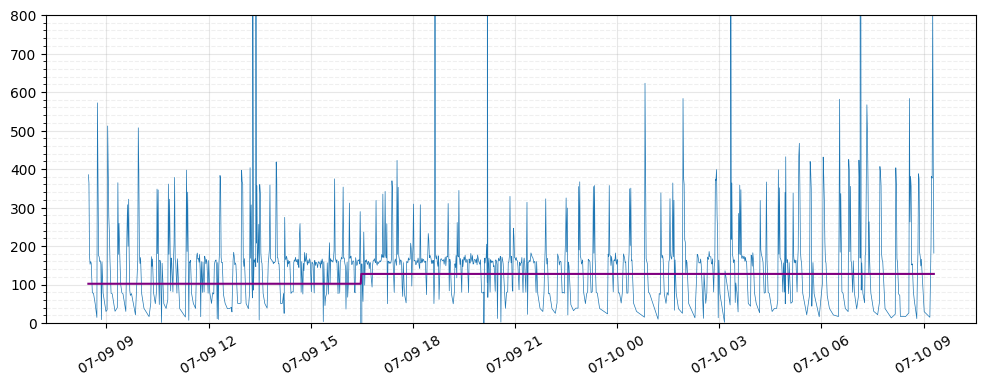

In [69]:
s = 5000
n = 1000

fig, ax1 = plt.subplots(figsize=(12, 4))


ax2.plot(df_press.iloc[s:s+n, :]['Timestamp'], df_press.iloc[s:s+n, :]['Value'], lw=0.5)

ax1.plot(df_daily.iloc[s:s+n, :]['Timestamp'], df_daily.iloc[s:s+n, :]['Inst_Flow_Rate'], lw=0.5)
ax1.plot(df_daily.iloc[s:s+n, :]['Timestamp'], df_daily.iloc[s:s+n, :]['Step_Value'], color='purple')

ax1.set_ylim(0, 800)
ax1.set_ylim(0, 800)

ax1.tick_params(axis='x', labelrotation=30)

ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.grid(axis='y', which='minor', linestyle='--', alpha=0.2)  # Minor grid lines
ax1.grid(axis='both', which='major', linestyle='-', alpha=0.3)  # Major grid lines



In [ ]:
s = 5000
n = 1000

fig, ax1 = plt.subplots(figsize=(12, 4))

ax1.plot(df_daily.iloc[s:s+n, :]['Timestamp'], df_daily.iloc[s:s+n, :]['Inst_Flow_Rate'], lw=0.5)
ax1.plot(df_daily.iloc[s:s+n, :]['Timestamp'], df_daily.iloc[s:s+n, :]['Step_Value'], color='purple')

ax1.set_ylim(0, 800)
ax1.set_ylim(0, 800)

ax1.tick_params(axis='x', labelrotation=30)

ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.grid(axis='y', which='minor', linestyle='--', alpha=0.2)  # Minor grid lines
ax1.grid(axis='both', which='major', linestyle='-', alpha=0.3)  # Major grid lines



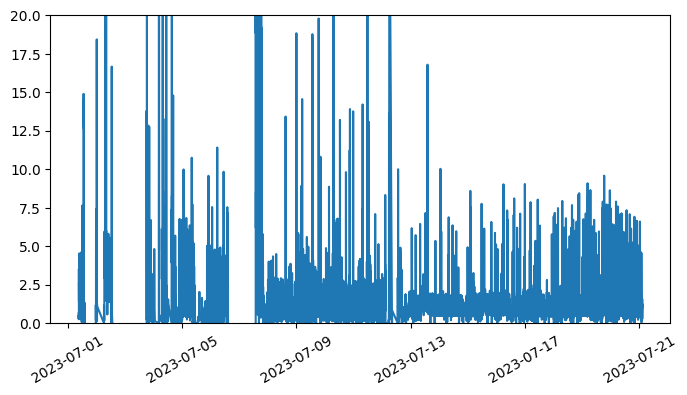

In [52]:
s = 0
n = 20000

fig, ax = plt.subplots(figsize=(8, 4))


ax.plot(df_daily.iloc[s:s+n, :]['Timestamp'], df_daily.iloc[s:s+n, :]['Inst / Cum Ratio'])

ax.set_ylim(0, 20)

ax.tick_params(axis='x', labelrotation=30)

In [23]:
df_daily.describe()

,Timestamp,Value,Step_Value,Value_Diff,Time_Diff,Inst_Flow_Rate,Inst / Cum Ratio
count,119740,119740.00000,119740.000000,119740.000000,119740.000000,1.197400e+05,119740.000000
mean,2023-08-18 06:29:40.988742144,863.34055,1737.127984,0.010411,65.662268,2.247254e+02,0.021991
min,2023-07-01 09:00:03,0.00000,8.750238,-4192.656239,4.000000,-3.140371e+07,-19395.899672
25%,2023-07-27 18:45:48.249999872,174.47995,471.942200,0.248240,59.000000,3.717218e+02,0.573883
50%,2023-08-17 12:11:33,495.96575,1941.742000,0.709200,60.000000,1.094621e+03,1.011877
75%,2023-09-09 07:05:18,1415.08475,2627.313000,1.833000,61.000000,2.876565e+03,1.472264
max,2023-09-30 08:59:05,4194.03700,4194.037000,32.167000,92340.000000,7.367760e+04,119.654021
std,NaN,863.63676,1179.824923,54.513303,388.787460,1.257905e+05,86.108343


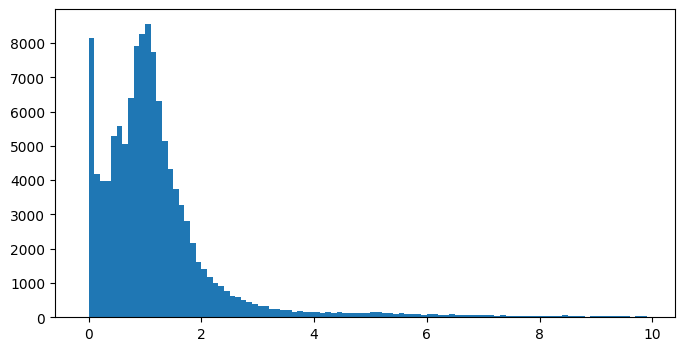

In [20]:
fig, ax = plt.subplots(figsize=(8, 4))

bins = np.arange(-0.1, 10, 0.1)
ax.hist(df_daily['Inst / Cum Ratio'], bins=bins);

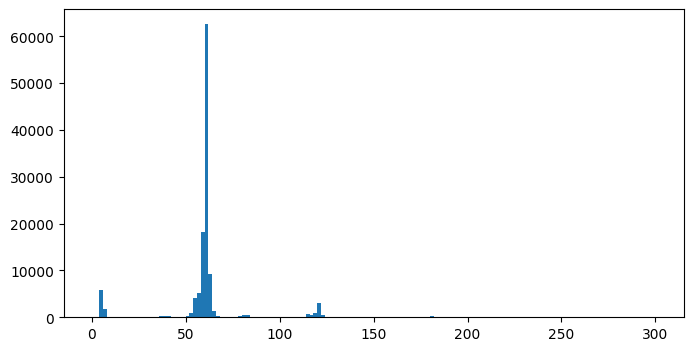

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(df_daily['Time_Diff'], bins=range(0, 300 + 2, 2));

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(df_daily['Time_Diff'], bins=range(0, 300 + 2, 2));